# User Defined Functions

From time to time you hit a wall where you need a simple transformation, but Spark does not offer an appropriate function in the `pyspark.sql.functions` module. Fortunately you can simply define new functions, so called *user defined functions* or short *UDFs*.

In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

df = spark.createDataFrame([('Alice & Bob',12),('Thelma & Louise',17)],['name','age'])
df.toPandas()

,name,age
0,Alice & Bob,12
1,Thelma & Louise,17


In [2]:
import html

html.escape("Thelma & Louise")

'Thelma &amp; Louise'

In [3]:
import html

html_encode = udf(lambda s: html.escape(s), StringType())

result = df.select(html_encode('name').alias('html_name'))
result.toPandas()

,html_name
0,Alice &amp; Bob
1,Thelma &amp; Louise


As an alternative, you can also use a Python decorator for declaring a UDF:

In [4]:
@udf(StringType())
def html_encode(s):
    return html.escape(s)

result = df.select(html_encode('name').alias('html_name'))
result.toPandas()

,html_name
0,Alice &amp; Bob
1,Thelma &amp; Louise


## Complex return types

PySpark also supports complex return types, for example structs (or also arrays)

In [5]:
@udf(StructType([
    StructField("org_name", StringType()), 
    StructField("html_name", StringType())
]))
def html_encode(s):
    return (s,html.escape(s))

result = df.select(html_encode('name').alias('both_names'))
result.toPandas()

,both_names
0,"(Alice & Bob, Alice &amp; Bob)"
1,"(Thelma & Louise, Thelma &amp; Louise)"


## SQL Support

If you wanto to use the Python UDF inside a SQL query, you also need to register it, so PySpark knows its name.

In [6]:
html_encode = spark.udf.register("html_encode", lambda s: html.escape(s), StringType())

df.createOrReplaceTempView("famous_pairs")
result = spark.sql("SELECT html_encode(name) FROM famous_pairs")
result.toPandas()

,html_encode(name)
0,Alice &amp; Bob
1,Thelma &amp; Louise


# Pandas UDFs

"Normal" Python UDFs are pretty expensive (in terms of execution time), since for every record the following steps need to be performed:
* record is serialized inside JVM
* record is sent to an external Python process
* record is deserialized inside Python
* record is Processed in Python
* result is serialized in Python
* result is sent back to JVM
* result is deserialized and stored inside result DataFrame

This does not only sound like a lot of work, it actually is. Therefore Python UDFs are a magnitude slower than native UDFs written in Scala or Java, which run directly inside the JVM.

But since Spark 2.3 an alternative approach is available for defining Python UDFs with so called *Pandas UDFs*. Pandas is a commonly used Python framework which also offers DataFrames (but Pandas DataFrames, not Spark DataFrames). Spark 2.3 now can convert inside the JVM a Spark DataFrame into a shareable memory buffer by using a library called *Arrow*. Python then can also treat this memory buffer as a Pandas DataFrame and can directly work on this shared memory.

This approach has two major advantages:
* No need for serialization and deserialization, since data is shared directly in memory between the JVM and Python
* Pandas has lots of very efficient implementations in C for many functions

Due to these two facts, Pandas UDFs are much faster and should be preferred over traditional Python UDFs whenever possible.

In [7]:
r = spark.range(0,100)
df = r.withColumn('v', r.id.cast("double")).withColumn("group", r.id % 5)
df.limit(10).toPandas()

,id,v,group
0,0,0.0,0
1,1,1.0,1
2,2,2.0,2
3,3,3.0,3
4,4,4.0,4
5,5,5.0,0
6,6,6.0,1
7,7,7.0,2
8,8,8.0,3
9,9,9.0,4


## Classic UDF Approach

As an example, let's create a function which simply increments a numeric column by one. First let us have a look using a traditional Python UDF:

In [8]:
from pyspark.sql.functions import udf

# Use udf to define a row-at-a-time udf
@udf('double')
# Input/output are both a single double value
def plus_one(v):
      return v + 1

result = df.withColumn('v2', plus_one(df.v))
result.limit(10).toPandas()

,id,v,group,v2
0,0,0.0,0,1.0
1,1,1.0,1,2.0
2,2,2.0,2,3.0
3,3,3.0,3,4.0
4,4,4.0,4,5.0
5,5,5.0,0,6.0
6,6,6.0,1,7.0
7,7,7.0,2,8.0
8,8,8.0,3,9.0
9,9,9.0,4,10.0


## Pandas UDF

Increment a value using a Pandas UDF. The Pandas UDF receives a `pandas.Series` object and also has to return a `pandas.Series` object.

In [9]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

# Use pandas_udf to define a Pandas UDF
@pandas_udf('double', PandasUDFType.SCALAR)
# Input/output are both a pandas.Series of doubles

def pandas_plus_one(v):
    return v + 1

result = df.withColumn('v2', pandas_plus_one(df.v))
result.limit(10).toPandas()

,id,v,group,v2
0,0,0.0,0,1.0
1,1,1.0,1,2.0
2,2,2.0,2,3.0
3,3,3.0,3,4.0
4,4,4.0,4,5.0
5,5,5.0,0,6.0
6,6,6.0,1,7.0
7,7,7.0,2,8.0
8,8,8.0,3,9.0
9,9,9.0,4,10.0


## Grouped Pandas UDFs
While the example above transforms all records independently, but only one column at a time, Spark also offers a so called *grouped Pandas UDF* which operates on complete groups of records (as created by a `groupBy` method). This is a great mean to replace the (in PySpark missing) *User Defined Aggregation Functions* (UDAFs).

For example let's subtract the mean of a group from all entries of a group. In Spark this could be achieved directly by using windowed aggregations. But let's first have a look at a Python implementation which does not use Pandas Grouped UDFs

In [29]:
import pandas as pd

@udf(ArrayType(DoubleType()))
def subtract_mean(values):
    series = pd.Series(values)
    center = series - series.mean()
    return [x for x in center]

groups = df.groupBy('group').agg(collect_list(df.v).alias('values'))
result = groups.withColumn('center', explode(subtract_mean(groups.values))).drop('values')
result.limit(10).toPandas()

,group,center
0,0,-47.5
1,0,-42.5
2,0,-37.5
3,0,-32.5
4,0,-27.5
5,0,-22.5
6,0,-17.5
7,0,-12.5
8,0,-7.5
9,0,-2.5


This example is even incomplete, as the `id` column is now missing.

### Using Pandas Grouped UDFs

Now let's try to implement the same function using a Pandas grouped UDF

In [27]:
@pandas_udf(df.schema, PandasUDFType.GROUPED_MAP)
# Input/output are both a pandas.DataFrame
def subtract_mean(pdf):
    return pdf.assign(v=pdf.v - pdf.v.mean())

result = df.groupby('group').apply(subtract_mean)
result.limit(10).toPandas()

,id,v,group
0,0,-47.5,0
1,5,-42.5,0
2,10,-37.5,0
3,15,-32.5,0
4,20,-27.5,0
5,25,-22.5,0
6,30,-17.5,0
7,35,-12.5,0
8,40,-7.5,0
9,45,-2.5,0


# Example of grouped regressions

In this section, we want to demanstrate a slightly advanced example for using Pandas grouped transformation for performing many ordinary least square model fits in parallel. We reuse the weather data and try to predict the temperature of all stations with a very simple model per station.

In [34]:
%matplotlib inline

### Load Data
First we load data of a single year.

In [30]:
storageLocation = "s3://dimajix-training/data/weather"

In [32]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

rawWeatherData = spark.read.text(storageLocation + "/2003")
weather_all = rawWeatherData.select(
    substring(col("value"),5,6).alias("usaf"),
    substring(col("value"),11,5).alias("wban"),
    to_timestamp(substring(col("value"),16,12),"yyyyMMddHHmm").alias("timestamp"),
    to_timestamp(substring(col("value"),16,12),"yyyyMMddHHmm").cast("long").alias("ts"),
    substring(col("value"),42,5).alias("report_type"),
    substring(col("value"),61,3).alias("wind_direction"),
    substring(col("value"),64,1).alias("wind_direction_qual"),
    substring(col("value"),65,1).alias("wind_observation"),
    (substring(col("value"),66,4).cast("float") / lit(10.0)).alias("wind_speed"),
    substring(col("value"),70,1).alias("wind_speed_qual"),
    (substring(col("value"),88,5).cast("float") / lit(10.0)).alias("air_temperature"),
    substring(col("value"),93,1).alias("air_temperature_qual")
)

## Analysis of one station

First we only analyse a single station, just to check our approach and the expressiveness of our model. It won't be a very good fit, but it will be good enough for our needs to demonstrate the concept.

So first we pick a single station, and we also only keep those records with a valid temeprature measurement.

In [56]:
weather_single = weather_all.where("usaf='954920' and wban='99999'").cache()

In [37]:
pdf = weather_single.where(weather_single.air_temperature_qual == 1).toPandas()
pdf

,usaf,wban,timestamp,ts,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,air_temperature,air_temperature_qual
0,954920,99999,2003-01-01 00:00:00,1041379200,FM-12,200,1,N,4.6,1,25.6,1
1,954920,99999,2003-01-01 02:00:00,1041386400,FM-12,230,1,N,5.7,1,27.8,1
2,954920,99999,2003-01-01 03:00:00,1041390000,FM-12,220,1,N,7.7,1,29.6,1
3,954920,99999,2003-01-01 05:00:00,1041397200,FM-12,230,1,N,6.2,1,29.7,1
4,954920,99999,2003-01-01 06:00:00,1041400800,FM-12,240,1,N,6.7,1,30.2,1
5,954920,99999,2003-01-01 08:00:00,1041408000,FM-12,210,1,N,6.7,1,29.1,1
6,954920,99999,2003-01-01 09:00:00,1041411600,FM-12,220,1,N,5.7,1,28.0,1
7,954920,99999,2003-01-01 11:00:00,1041418800,FM-12,210,1,N,3.6,1,25.9,1
8,954920,99999,2003-01-01 12:00:00,1041422400,FM-12,200,1,N,4.1,1,25.0,1
9,954920,99999,2003-01-01 14:00:00,1041429600,FM-12,190,1,N,6.2,1,23.0,1


### Create Feature Space

Our model will simply predict the temperature depending on the time and day of year. We use sin and cos of with a day-wide period and a year-wide period as features for fitting the model.

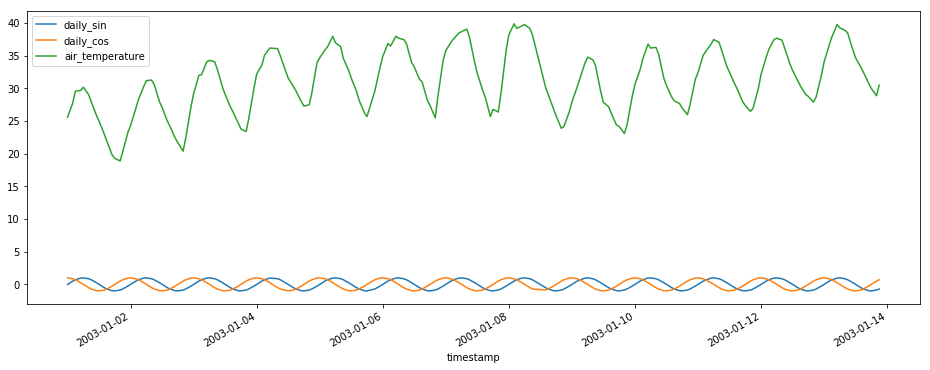

In [57]:
import numpy as np
import math

seconds_per_day = 24*60*60
seconds_per_year = 365*seconds_per_day

# Add sin and cos as features for fitting
pdf['daily_sin'] = np.sin(pdf['ts']/seconds_per_day*2.0*math.pi)
pdf['daily_cos'] = np.cos(pdf['ts']/seconds_per_day*2.0*math.pi)
pdf['yearly_sin'] = np.sin(pdf['ts']/seconds_per_year*2.0*math.pi)
pdf['yearly_cos'] = np.cos(pdf['ts']/seconds_per_year*2.0*math.pi)

# Make a plot, just to check how it looks like
pdf[0:200].plot(x='timestamp', y=['daily_sin','daily_cos','air_temperature'], figsize=[16,6])

### Fit model

Now that we have the temperature and some features, we fit a simple model.

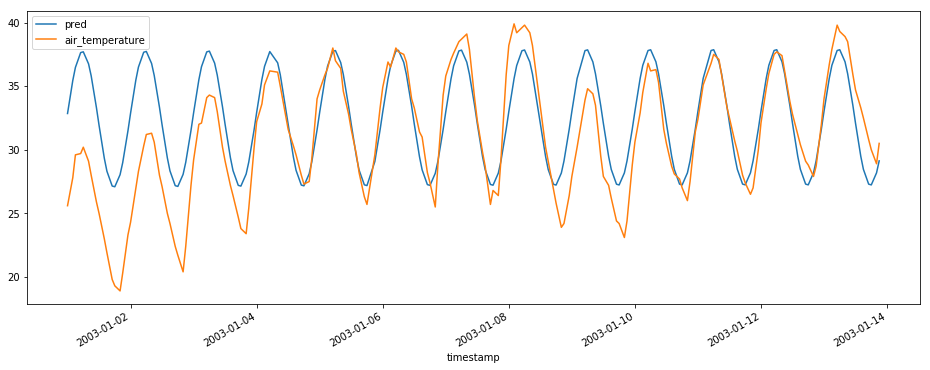

In [70]:
import statsmodels.api as sm

# define target variable y
y = pdf['air_temperature']
# define feature variables X
X = pdf[['ts', 'daily_sin', 'daily_cos', 'yearly_sin', 'yearly_cos']]
X = sm.add_constant(X)
# fit model
model = sm.OLS(y, X).fit()

# perform prediction
pdf['pred'] = model.predict(X)

# Make a plot of real temperature vs predicted temperature
pdf[0:200].plot(x='timestamp', y=['pred','air_temperature'], figsize=[16,6])

### Inspect Model

Now let us inspect the model, in order to find a way to store it in a Pandas DataFrame

In [71]:
model.params

const         1.836431e+01
ts            4.503481e-09
daily_sin     5.313380e+00
daily_cos     4.699659e-01
yearly_sin    3.045510e+00
yearly_cos    8.993267e+00
dtype: float64

In [72]:
type(model.params)

pandas.core.series.Series

Create a DataFrame from the model parameters

In [73]:
x_columns = X.columns
pd.DataFrame([[model.params[i] for i in  x_columns]], columns=x_columns)

,const,ts,daily_sin,daily_cos,yearly_sin,yearly_cos
0,18.364309,4.503481e-09,5.31338,0.469966,3.04551,8.993267


## Perform OLS for all stations

Now we want to create a model for all stations. First we filter the data again, such that we only have valid temperature measurements.

In [75]:
valid_weather = weather_all.filter(weather_all.air_temperature_qual == 1)

### Feature extraction

Now we generate the same features, but this time we use Spark instead of Pandas operations. This simplifies later model fitting.

In [89]:
import math

seconds_per_day = 24*60*60
seconds_per_year = 365*seconds_per_day

features = valid_weather.select(
    valid_weather.usaf,
    valid_weather.wban,
    valid_weather.air_temperature,
    valid_weather.ts,
    lit(1.0).alias('const'),
    sin(valid_weather.ts * 2.0 * math.pi / seconds_per_day).alias('daily_sin'),
    cos(valid_weather.ts * 2.0 * math.pi / seconds_per_day).alias('daily_cos'),
    sin(valid_weather.ts * 2.0 * math.pi / seconds_per_year).alias('yearly_sin'),
    cos(valid_weather.ts * 2.0 * math.pi / seconds_per_year).alias('yearly_cos')
)

features.limit(10).toPandas()

,usaf,wban,air_temperature,ts,const,daily_sin,daily_cos,yearly_sin,yearly_cos
0,703160,25624,-2.0,1041380220,1.0,0.074108,0.997250,0.137480,0.990505
1,703160,25624,2.0,1041400380,1.0,0.999534,0.030539,0.141457,0.989944
2,703160,25624,-3.0,1041421980,1.0,0.030539,-0.999534,0.145716,0.989326
3,703160,25624,-4.0,1041443580,1.0,-0.999534,-0.030539,0.149973,0.988690
4,703160,25624,-3.0,1041465180,1.0,-0.030539,0.999534,0.154226,0.988036
5,703160,25624,-2.0,1041486780,1.0,0.999534,0.030539,0.158477,0.987363
6,703160,25624,-2.0,1041489960,1.0,0.979925,-0.199368,0.159102,0.987262
7,703160,25624,-2.0,1041490920,1.0,0.963630,-0.267238,0.159291,0.987232
8,703160,25624,-2.0,1041499380,1.0,0.632705,-0.774393,0.160955,0.986962
9,703160,25624,-2.0,1041501960,1.0,0.477159,-0.878817,0.161462,0.986879


### Fit Models

Now we use a Spark Pandas grouped UDF in order to fit models for all weather stations in parallel.

In [90]:
group_columns = ['usaf', 'wban']
y_column = 'air_temperature'
x_columns = ['ts', 'const', 'daily_sin', 'daily_cos', 'yearly_sin', 'yearly_cos']
schema = features.select(*group_columns, *x_columns).schema

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def ols(pdf):
    group = [pdf[g].iloc[0] for g in group_columns]
    y = pdf[y_column]
    X = pdf[x_columns]
    model = sm.OLS(y, X).fit()
    return pd.DataFrame([group + [model.params[i] for i in x_columns]], columns=group_columns + x_columns)

models = features.groupby(weather_all.usaf, weather_all.wban).apply(ols).cache()

In [91]:
models.limit(10).toPandas()

,usaf,wban,ts,const,daily_sin,daily_cos,yearly_sin,yearly_cos
0,954920,99999,0,18.364309,5.313380,0.469966,3.045510,8.993267
1,038940,99999,0,25.272246,-0.826144,-1.376067,-3.693573,-4.713150
2,999999,94074,0,-5.866619,-4.867254,4.548186,-2.788635,-13.403601
3,111200,99999,0,-73.725936,-2.577125,-3.810438,-3.091114,-11.116201
4,727923,94225,0,178.539020,-0.597472,1.318946,-5.304252,-2.788685
5,701330,26616,0,207.711918,0.154068,0.326450,-9.337710,-11.273081
6,724273,03804,0,-138.120951,-1.752578,1.236404,-4.714701,-10.270727
7,726410,14837,0,-88.717287,-1.930264,2.198496,-6.594899,-11.926900
8,725560,14941,0,21.283986,-2.378156,3.185683,-5.713081,-13.298528
9,028450,99999,0,-188.638633,-0.772881,-1.636365,-3.677941,-12.949335


## Inspect and compare results

Now let's pick the same station again, and compare the model to the original model.

In [92]:
models.where("usaf='954920' and wban='99999'").toPandas()

,usaf,wban,ts,const,daily_sin,daily_cos,yearly_sin,yearly_cos
0,954920,99999,0,18.364309,5.31338,0.469966,3.04551,8.993267


In [85]:
model.params

const         1.836431e+01
ts            4.503481e-09
daily_sin     5.313380e+00
daily_cos     4.699659e-01
yearly_sin    3.045510e+00
yearly_cos    8.993267e+00
dtype: float64